# Movie Data Analysis Notebook

This notebook orchestrates the analysis of movie data from The Movie Database (TMDB) using functions defined in `movie_analysis.py`. It includes data extraction, cleaning, KPI calculations, rankings, searches, franchise analysis, and visualizations.

## Setup and Imports

Import required libraries and the custom movie analysis module. Ensure the TMDB API key is set as an environment variable (`API_KEY`).

In [7]:
import os
import tmdb_pipeline
from pyspark.sql import SparkSession

# Set TMDB API key as environment variable (replace 'your_api_key_here' with your actual key)
os.environ['API_KEY'] = "1711e9fb61ca62e3a5ec25f5e79a2df8"

# Verify API key
api_key = tmdb_pipeline.load_api_key()
if not api_key:
    raise ValueError("API key not found. Please set the 'API_KEY' environment variable.")

# Initialize Spark session
spark = tmdb_pipeline.create_spark_session()
print("Spark session initialized successfully.")

Spark session initialized successfully.


## Data Extraction

Fetch movie data from TMDB API for a predefined list of movie IDs and save it as a Parquet file.

In [8]:
# Define movie IDs
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397,
    420818, 24428, 168259, 99861, 284054, 12445,
    181808, 330457, 351286, 109445, 321612, 260513
]

# Extract and save movie data
df = tmdb_pipeline.extract_movie_data(spark, movie_ids, api_key)
df = tmdb_pipeline.save_and_load_dataframe(df, spark)
print("Movie data extracted and saved successfully.")
df.show(5)

Request error for movie ID 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?append_to_response=credits&api_key=1711e9fb61ca62e3a5ec25f5e79a2df8&language=en-US


Movie data extracted and saved successfully.
+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+--------------------+
|adult|       backdrop_path|belongs_to_collection|   budget|              genres|            homepage|    id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|             credits|
+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+-----------------+

## Data Cleaning

Clean the DataFrame by dropping irrelevant columns, extracting nested fields, converting data types, scaling budgets and revenues, and reordering columns.

In [9]:
# Clean the DataFrame
df = tmdb_pipeline.drop_irrelevant_columns(df)
df = tmdb_pipeline.extract_nested_columns(df)
df = tmdb_pipeline.extract_cast_and_crew(df)
df = tmdb_pipeline.convert_column_types(df)
df = tmdb_pipeline.replace_zero_with_nan(df, ['budget', 'revenue', 'runtime'])
df = tmdb_pipeline.scale_budget_and_revenue(df)
df = tmdb_pipeline.adjust_vote_average(df)
df = tmdb_pipeline.replace_placeholders_with_nan(df, ['overview', 'tagline'])
df = tmdb_pipeline.clean_dataframe(df)

# Reorder columns
desired_order = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size'
]
df = tmdb_pipeline.reorder_columns(df, desired_order)

print("Data cleaned and columns reordered.")
df.show(5)

Data cleaned and columns reordered.


+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+-------------+---------+
|   id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|     director|crew_size|
+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+

## KPI Calculations and Rankings

Calculate key performance indicators (profit and ROI) and rank movies based on various metrics.

In [11]:
# Calculateeverywhere
# Calculate KPIs
df = tmdb_pipeline.calculate_kpis(df)

# Perform rankings
tmdb_pipeline.rank_highest_revenue(df)
tmdb_pipeline.rank_highest_budget(df)
tmdb_pipeline.rank_highest_profit(df)
tmdb_pipeline.rank_lowest_profit(df)
tmdb_pipeline.rank_highest_roi(df)
tmdb_pipeline.rank_lowest_roi(df)
tmdb_pipeline.rank_most_voted(df)
tmdb_pipeline.rank_highest_rated(df)
tmdb_pipeline.rank_lowest_rated(df)
tmdb_pipeline.rank_most_popular(df)

Highest Revenue:


25/04/25 01:14:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+------------+----+
|    id|               title|revenue_musd|rank|
+------+--------------------+------------+----+
| 19995|              Avatar| 2923.706026|   1|
|299534|   Avengers: Endgame|   2799.4391|   2|
|   597|             Titanic| 2264.162353|   3|
|140607|Star Wars: The Fo...| 2068.223624|   4|
|299536|Avengers: Infinit...| 2052.415039|   5|
|135397|      Jurassic World| 1671.537444|   6|
|420818|       The Lion King| 1662.020819|   7|
| 24428|        The Avengers| 1518.815515|   8|
|168259|           Furious 7|      1515.4|   9|
|330457|           Frozen II| 1453.683476|  10|
+------+--------------------+------------+----+


Highest Budget:


25/04/25 01:14:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+-----------+----+
|    id|               title|budget_musd|rank|
+------+--------------------+-----------+----+
| 99861|Avengers: Age of ...|      365.0|   1|
|299534|   Avengers: Endgame|      356.0|   2|
|299536|Avengers: Infinit...|      300.0|   3|
|420818|       The Lion King|      260.0|   4|
|140607|Star Wars: The Fo...|      245.0|   5|
| 19995|              Avatar|      237.0|   6|
| 24428|        The Avengers|      220.0|   7|
|   597|             Titanic|      200.0|   8|
|181808|Star Wars: The La...|      200.0|   8|
|260513|       Incredibles 2|      200.0|   8|
+------+--------------------+-----------+----+


Highest Profit:


25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+------------------+----+
|    id|               title|            profit|rank|
+------+--------------------+------------------+----+
| 19995|              Avatar|       2686.706026|   1|
|299534|   Avengers: Endgame|         2443.4391|   2|
|   597|             Titanic|       2064.162353|   3|
|140607|Star Wars: The Fo...|1823.2236240000002|   4|
|299536|Avengers: Infinit...|       1752.415039|   5|
|135397|      Jurassic World|       1521.537444|   6|
|420818|       The Lion King|       1402.020819|   7|
|168259|           Furious 7|            1325.4|   8|
|330457|           Frozen II|       1303.683476|   9|
| 24428|        The Avengers|       1298.815515|  10|
+------+--------------------+------------------+----+


Lowest Profit:


25/04/25 01:14:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+-----------+----+
|    id|               title|     profit|rank|
+------+--------------------+-----------+----+
| 99861|Avengers: Age of ...|1040.403694|   1|
|260513|       Incredibles 2|1042.805359|   2|
|321612|Beauty and the Beast|1106.115964|   3|
|109445|              Frozen|1124.219009|   4|
|181808|Star Wars: The La...| 1132.69883|   5|
|351286|Jurassic World: F...|1140.466296|   6|
|284054|       Black Panther|1149.926083|   7|
| 12445|Harry Potter and ...|1216.511219|   8|
| 24428|        The Avengers|1298.815515|   9|
|330457|           Frozen II|1303.683476|  10|
+------+--------------------+-----------+----+


Highest ROI (Budget >= 10M):


25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+-----------------+----+
|    id|               title|              roi|rank|
+------+--------------------+-----------------+----+
| 19995|              Avatar|12.33631234599156|   1|
|   597|             Titanic|     11.320811765|   2|
|135397|      Jurassic World|      11.14358296|   3|
| 12445|Harry Potter and ...|     10.732089752|   4|
|330457|           Frozen II|9.691223173333332|   5|
|109445|              Frozen|8.494793393333333|   6|
|140607|Star Wars: The Fo...|8.441729077551022|   7|
|168259|           Furious 7|7.975789473684211|   8|
|321612|Beauty and the Beast|7.913224775000001|   9|
|299534|   Avengers: Endgame| 7.86359297752809|  10|
+------+--------------------+-----------------+----+


Lowest ROI (Budget >= 10M):


25/04/25 01:14:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+------------------+----+
|    id|               title|               roi|rank|
+------+--------------------+------------------+----+
| 99861|Avengers: Age of ...| 3.850421079452055|   1|
|260513|       Incredibles 2|       6.214026795|   2|
|420818|       The Lion King|6.3923877653846155|   3|
|181808|Star Wars: The La...|        6.66349415|   4|
|284054|       Black Panther|       6.749630415|   5|
|299536|Avengers: Infinit...| 6.841383463333333|   6|
| 24428|        The Avengers| 6.903706886363636|   7|
|351286|Jurassic World: F...| 7.708625270588236|   8|
|299534|   Avengers: Endgame|  7.86359297752809|   9|
|321612|Beauty and the Beast| 7.913224775000001|  10|
+------+--------------------+------------------+----+


Most Voted Movies:


25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+----------+----+
|    id|               title|vote_count|rank|
+------+--------------------+----------+----+
| 19995|              Avatar|     32163|   1|
| 24428|        The Avengers|     31635|   2|
|299536|Avengers: Infinit...|     30442|   3|
|299534|   Avengers: Endgame|     26258|   4|
|   597|             Titanic|     25922|   5|
| 99861|Avengers: Age of ...|     23374|   6|
|284054|       Black Panther|     22513|   7|
| 12445|Harry Potter and ...|     20975|   8|
|135397|      Jurassic World|     20652|   9|
|140607|Star Wars: The Fo...|     19698|  10|
+------+--------------------+----------+----+


Highest Rated Movies (Votes >= 10):


25/04/25 01:14:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+------------+----+
|    id|               title|vote_average|rank|
+------+--------------------+------------+----+
|299534|   Avengers: Endgame|       8.237|   1|
|299536|Avengers: Infinit...|       8.235|   2|
| 12445|Harry Potter and ...|       8.087|   3|
|   597|             Titanic|       7.905|   4|
| 24428|        The Avengers|        7.74|   5|
| 19995|              Avatar|       7.588|   6|
|260513|       Incredibles 2|       7.454|   7|
|284054|       Black Panther|       7.373|   8|
| 99861|Avengers: Age of ...|       7.271|   9|
|140607|Star Wars: The Fo...|       7.261|  10|
+------+--------------------+------------+----+


Lowest Rated Movies (Votes >= 10):


25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+------------+----+
|    id|               title|vote_average|rank|
+------+--------------------+------------+----+
|351286|Jurassic World: F...|       6.538|   1|
|135397|      Jurassic World|       6.693|   2|
|181808|Star Wars: The La...|       6.778|   3|
|321612|Beauty and the Beast|       6.971|   4|
|420818|       The Lion King|        7.11|   5|
|168259|           Furious 7|       7.226|   6|
|109445|              Frozen|       7.246|   7|
|330457|           Frozen II|       7.249|   8|
|140607|Star Wars: The Fo...|       7.261|   9|
| 99861|Avengers: Age of ...|       7.271|  10|
+------+--------------------+------------+----+


Most Popular Movies:


25/04/25 01:14:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 01:14:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+----------+----+
|    id|               title|popularity|rank|
+------+--------------------+----------+----+
|299536|Avengers: Infinit...|   87.9166|   1|
|420818|       The Lion King|   53.5223|   2|
|284054|       Black Panther|   51.8631|   3|
|321612|Beauty and the Beast|   50.0247|   4|
|299534|   Avengers: Endgame|   47.7377|   5|
|181808|Star Wars: The La...|   45.6031|   6|
|   597|             Titanic|   45.5309|   7|
|351286|Jurassic World: F...|   43.9104|   8|
| 24428|        The Avengers|   38.6284|   9|
| 19995|              Avatar|   26.5692|  10|
+------+--------------------+----------+----+



## Specific Searches

Perform targeted searches for specific actors and directors.

In [12]:
# Search for Sci-Fi Action movies with Bruce Willis
tmdb_pipeline.search_bruce_willis_scifi_action(df)

# Search for Uma Thurman movies directed by Quentin Tarantino
tmdb_pipeline.search_uma_thurman_tarantino(df)


Search: Sci-Fi Action movies with Bruce Willis
+-----+------+----+------------+----------+
|title|genres|cast|vote_average|vote_count|
+-----+------+----+------------+----------+
+-----+------+----+------------+----------+


Search: Uma Thurman movies directed by Quentin Tarantino
+-----+----+--------+-------+
|title|cast|director|runtime|
+-----+----+--------+-------+
+-----+----+--------+-------+



## Franchise and Standalone Analysis

Compare performance metrics of franchise vs. standalone movies and analyze franchise performance.

In [13]:
# Compare franchise vs. standalone metrics
tmdb_pipeline.compare_franchise_standalone_metrics(df)

# Analyze franchise performance
tmdb_pipeline.analyze_franchise_performance(df)


Franchise vs. Standalone Movie Performance Comparison:
+----------------+------------------+-----------------+----------------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+-------------------+
|franchise_status| revenue_musd_mean|         roi_mean|budget_musd_mean|  popularity_mean|vote_average_mean|revenue_musd_median|       roi_median|budget_musd_median| popularity_median|vote_average_median|
+----------------+------------------+-----------------+----------------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+-------------------+
|       Franchise|1682.6419708124997|8.000174311158963|         219.875|33.03605020046234| 7.38037496805191|        1484.541738|7.786109124058163|             200.0|24.930500030517578|  7.266000032424927|
|      Standalone|1765.1391585000001|       9.61701827|           180.0|47.77779960632324|7.438000202178955| 1765.1391585000

## Visualizations

Generate visualizations to explore trends and comparisons in the movie data.

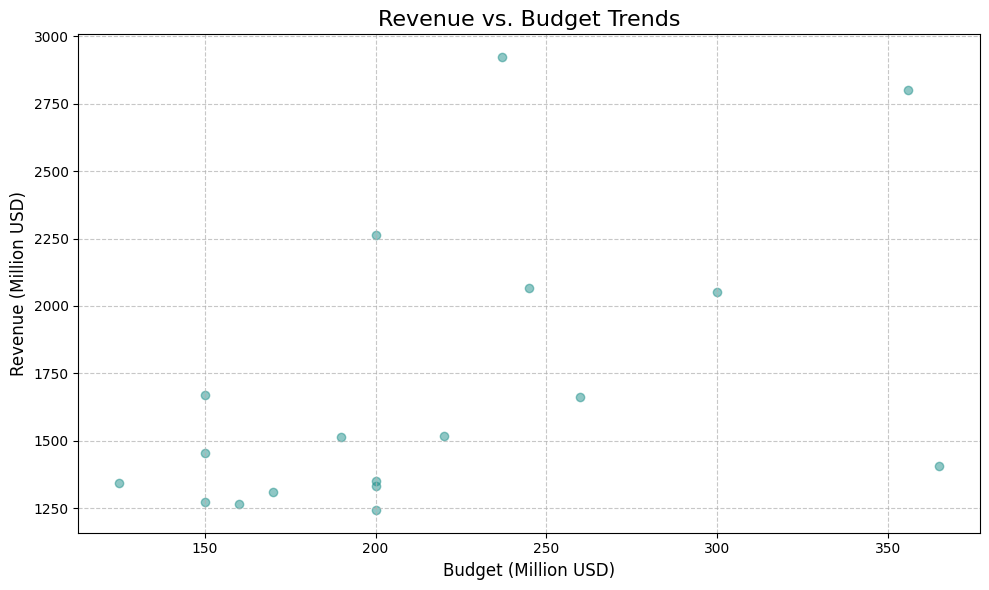

/home/sena/Desktop/DATA_ENGINEERING_pROJECTS/Project_03_TMDB_pySparkAnalysis/src/tmdb_pipeline.py:416: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=genre_labels, y=roi_data_all_genres, palette="husl")


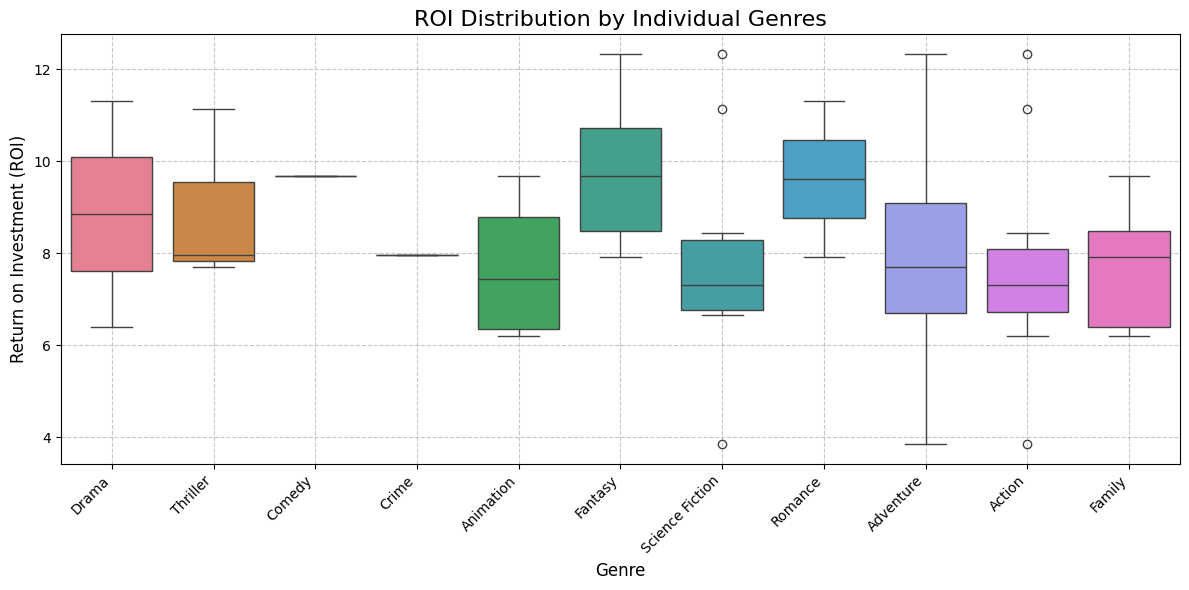

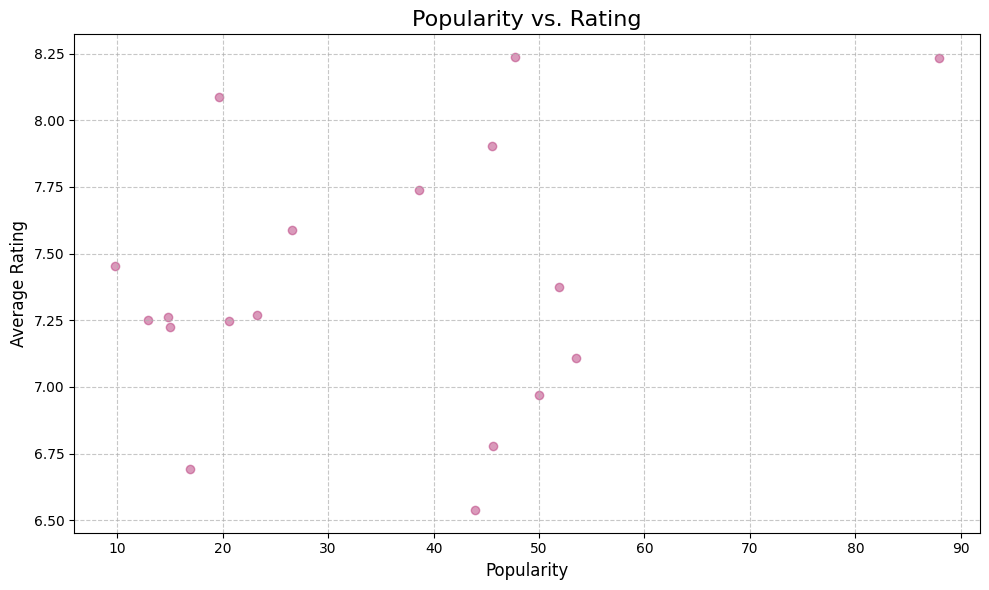

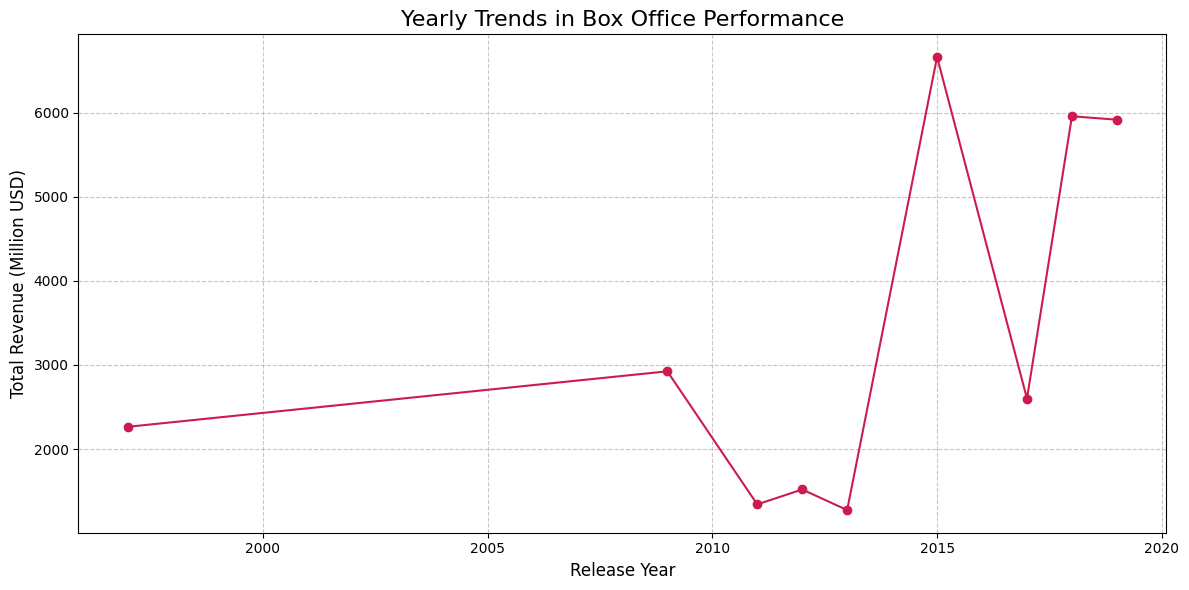

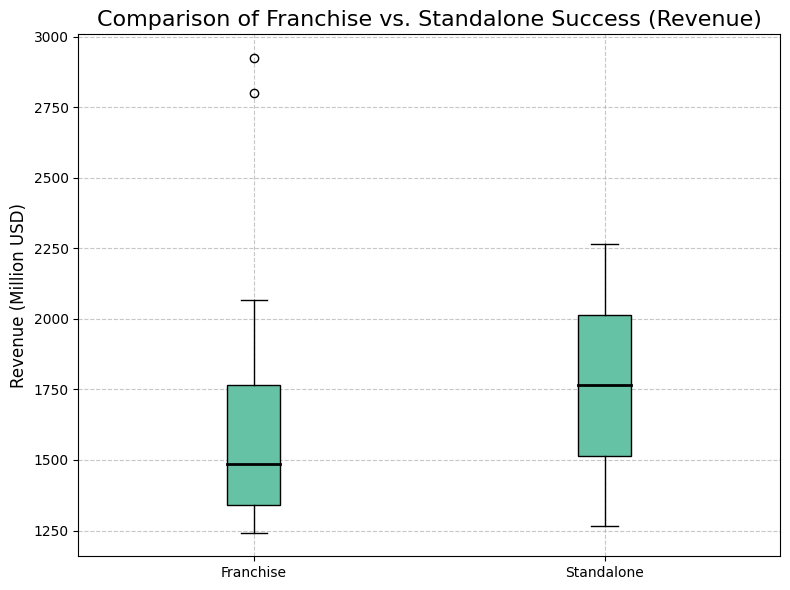

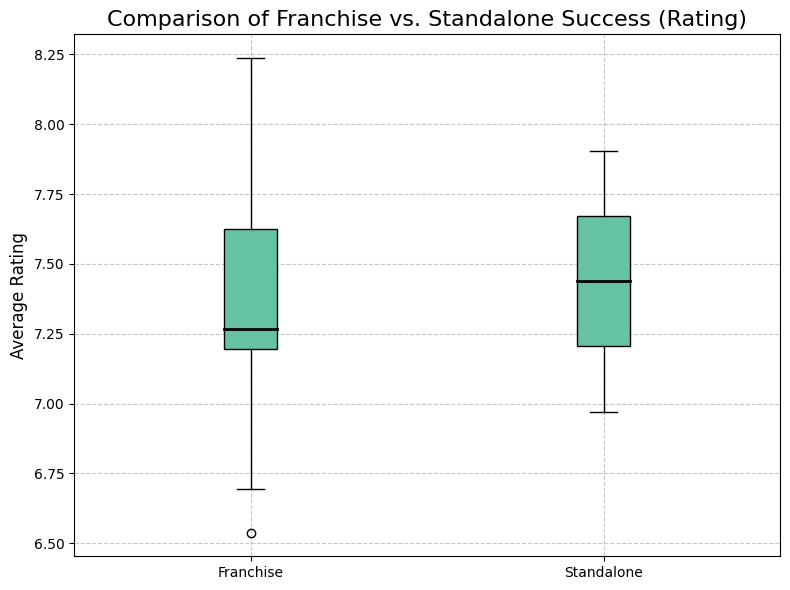

In [15]:
# Convert to Pandas DataFrame for visualizations
from pyspark.sql import functions as F
from pyspark.sql.functions import col
pandas_df = df.withColumn(
    'franchise_status',
    F.when(~F.isnan(col("belongs_to_collection")), F.lit('Franchise')).otherwise(F.lit('Standalone'))
).toPandas()

# Generate plots
tmdb_pipeline.plot_revenue_vs_budget(pandas_df)
tmdb_pipeline.plot_roi_by_genre(pandas_df)
tmdb_pipeline.plot_popularity_vs_rating(pandas_df)
tmdb_pipeline.plot_yearly_box_office_trends(pandas_df)
tmdb_pipeline.plot_franchise_vs_standalone_revenue(pandas_df)
tmdb_pipeline.plot_franchise_vs_standalone_rating(pandas_df)

## Cleanup

Stop the Spark session to release resources.

In [ ]:
# Stop Spark session
spark.stop()
print("Spark session stopped.")